In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cell 1: Extract and organize the dataset
import zipfile
import os
import cv2

# Define the path to your zip file
zip_path = '/content/drive/MyDrive/anamoly_detection/Datasets_new.zip'

# Unzip the folder
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/New__processed')

# Verify the structure
!ls /content/New__processed


Datasets_new


In [ ]:
# Function to convert videos to frames
def video_to_frames(video_path, output_folder, sequence_length=64):
    cap = cv2.VideoCapture(video_path)
    success, frame = cap.read()
    sequence_count = 0
    while success:
        sequence_folder = os.path.join(output_folder, f"sequence_{sequence_count:04d}")
        os.makedirs(sequence_folder, exist_ok=True)
        for count in range(sequence_length):
            if not success:
                break
            frame_filename = os.path.join(sequence_folder, f"frame_{count:04d}.jpg")
            cv2.imwrite(frame_filename, frame)
            success, frame = cap.read()
        sequence_count += 1
    cap.release()

# Base path to the dataset
base_path = "/content/New__processed/Datasets_new"
categories = ["train", "valid", "test"]
subcategories = ["normal_videos", "Vandalism", "Fighting"]

# Convert all videos to frames
for category in categories:
    for subcategory in subcategories:
        video_folder = os.path.join(base_path, category, subcategory)
        output_folder = os.path.join(base_path, category, f"{subcategory}_frames")
        os.makedirs(output_folder, exist_ok=True)

        for video_file in os.listdir(video_folder):
            video_path = os.path.join(video_folder, video_file)
            video_to_frames(video_path, output_folder)

In [ ]:
# Cell 2: Data augmentation and dataset creation
import tensorflow as tf
import numpy as np

# Data augmentation function
def augment_frame(frame):
    frame = tf.image.random_flip_left_right(frame)
    frame = tf.image.random_flip_up_down(frame)
    frame = tf.image.random_brightness(frame, max_delta=0.1)
    frame = tf.image.random_contrast(frame, lower=0.9, upper=1.1)
    return frame

# Load and preprocess image sequences
def load_and_preprocess_sequence(sequence_folder, sequence_length=64, target_size=(224, 224), augment=False):
    frames = sorted([os.path.join(sequence_folder, img) for img in os.listdir(sequence_folder) if img.endswith('.jpg')])
    if len(frames) == sequence_length:
        frames_array = [tf.keras.preprocessing.image.load_img(frame, target_size=target_size) for frame in frames]
        frames_array = [tf.keras.preprocessing.image.img_to_array(frame) for frame in frames_array]
        frames_array = [frame / 255.0 for frame in frames_array]
        if augment:
            frames_array = [augment_frame(frame) for frame in frames_array]
        return np.array(frames_array, dtype=np.float32)
    return None

# Create TensorFlow datasets
def create_tf_dataset(base_path, category, sequence_length=64, target_size=(224, 224), augment=False):
    label_mapping = {"Fighting": 0, "Vandalism": 1, "normal_videos": 2}
    datasets = []
    for subcategory in ["normal_videos", "Vandalism", "Fighting"]:
        dataset_path = os.path.join(base_path, category, f"{subcategory}_frames")
        sequence_folders = [os.path.join(dataset_path, seq_folder) for seq_folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, seq_folder))]

        def gen():
            for seq_folder in sequence_folders:
                sequence = load_and_preprocess_sequence(seq_folder, sequence_length, target_size, augment)
                if sequence is not None:
                    label = label_mapping[subcategory]
                    yield sequence, label

        dataset = tf.data.Dataset.from_generator(gen, output_signature=(tf.TensorSpec(shape=(sequence_length, target_size[0], target_size[1], 3), dtype=tf.float32),
                                                                         tf.TensorSpec(shape=(), dtype=tf.int32)))
        datasets.append(dataset)
    return datasets

# Create augmented and non-augmented datasets
train_datasets = create_tf_dataset(base_path, "train", augment=True)
valid_datasets = create_tf_dataset(base_path, "valid")
test_datasets = create_tf_dataset(base_path, "test")

train_dataset = train_datasets[0].concatenate(train_datasets[1]).concatenate(train_datasets[2])
valid_dataset = valid_datasets[0].concatenate(valid_datasets[1]).concatenate(valid_datasets[2])
test_dataset = test_datasets[0].concatenate(test_datasets[1]).concatenate(test_datasets[2])

# Shuffle and batch datasets
batch_size = 8
train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
# Cell 3: Model building and training
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def build_i3d_model(input_shape=(64, 224, 224, 3), num_classes=3):
    inputs = layers.Input(shape=input_shape)

    # Using a different backbone for better results
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape[1:])
    base_model.trainable = False

    time_distributed_features = layers.TimeDistributed(base_model)(inputs)
    x = layers.TimeDistributed(layers.GlobalAveragePooling2D())(time_distributed_features)
    x = layers.BatchNormalization()(x)
    x = layers.LSTM(256, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.LSTM(128, return_sequences=False, kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=predictions)
    return model

# Build and compile the model
input_shape = (64, 224, 224, 3)
num_classes = 3
i3d_model = build_i3d_model(input_shape=input_shape, num_classes=num_classes)
initial_learning_rate = 1e-3
i3d_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='/content/logs', histogram_freq=1)

# Training the model
history = i3d_model.fit(
    train_dataset,
    epochs=50,
    validation_data=valid_dataset,
    callbacks=[early_stopping, reduce_lr, tensorboard_callback]
)


94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/50
154/154 [==============================] - 734s 3s/step - loss: 4.8627 - accuracy: 0.9780 - val_loss: 1.4747 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/50


In [ ]:
# Cell 3: Model building and training
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def build_i3d_model(input_shape=(64, 224, 224, 3), num_classes=3):
    inputs = layers.Input(shape=input_shape)

    # Using a different backbone for better results
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape[1:])
    base_model.trainable = False

    time_distributed_features = layers.TimeDistributed(base_model)(inputs)
    x = layers.TimeDistributed(layers.GlobalAveragePooling2D())(time_distributed_features)
    x = layers.BatchNormalization()(x)
    x = layers.LSTM(256, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.LSTM(128, return_sequences=False, kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=predictions)
    return model

# Build and compile the model
input_shape = (64, 224, 224, 3)
num_classes = 3
i3d_model = build_i3d_model(input_shape=input_shape, num_classes=num_classes)
initial_learning_rate = 1e-3
i3d_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Training the model
history = i3d_model.fit(
    train_dataset,
    epochs=50,
    validation_data=valid_dataset,
    callbacks=[early_stopping, reduce_lr]
)


94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/50
154/154 [==============================] - 735s 3s/step - loss: 5.3815 - accuracy: 0.9699 - val_loss: 1.8307 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/50
154/154 [==============================] - 659s 2s/step - loss: 1.1068 - accuracy: 1.0000 - val_loss: 0.6281 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/50
154/154 [==============================] - 671s 2s/step - loss: 0.4027 - accuracy: 1.0000 - val_loss: 0.2329 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/50
154/154 [==============================] - 661s 2s/step - loss: 0.1580 - accuracy: 1.0000 - val_loss: 0.0950 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/50
154/154 [==============================] - 688s 2s/step - loss: 0.0780 - accuracy: 1.0000 - val_loss: 0.0476 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/50
154/154 [==============================] - 656s 2s/step - loss: 0.1080 - accuracy: 1.0000 - val_loss: 0.7315 - val_accuracy: 1.0000 - lr: 0.0010

KeyboardInterrupt: 

In [ ]:
# Evaluate the model
test_loss, test_accuracy = i3d_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


40/40 [==============================] - 38s 930ms/step - loss: 0.0292 - accuracy: 1.0000
Test Loss: 0.029248444363474846
Test Accuracy: 1.0


In [ ]:
# Save the model
model_save_path = '/content/i3d(bhau_new)_model.keras'
i3d_model.save(model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to /content/i3d(bhau_new)_model.keras


In [ ]:
# Plot accuracy and loss
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)


NameError: name 'history' is not defined

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions and true labels
y_true = []
y_pred = []

for sequences, labels in test_dataset:
    preds = np.argmax(i3d_model.predict(sequences), axis=-1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Classification report
class_report = classification_report(y_true, y_pred, target_names=["Fighting", "Vandalism", "Normal"])

print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Fighting", "Vandalism", "Normal"], yticklabels=["Fighting", "Vandalism", "Normal"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 0s 126ms/step


ValueError: Number of classes, 1, does not match size of target_names, 3. Try specifying the labels parameter

In [ ]:
# Evaluate the model
test_loss, test_accuracy = i3d_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


40/40 [==============================] - 37s 921ms/step - loss: 2.1879 - accuracy: 0.5623
Test Loss: 2.1879138946533203
Test Accuracy: 0.5623003244400024


In [ ]:
# Training the model
history = i3d_model.fit(
    train_dataset,
    epochs=100,
    validation_data=valid_dataset,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/100
102/102 [==============================] - 272s 1s/step - loss: 28.8512 - accuracy: 0.8922 - val_loss: 28.3991 - val_accuracy: 0.0577 - lr: 1.0000e-04
Epoch 2/100
102/102 [==============================] - 211s 1s/step - loss: 25.2723 - accuracy: 0.9841 - val_loss: 24.9692 - val_accuracy: 0.1168 - lr: 1.0000e-04
Epoch 3/100
102/102 [==============================] - 211s 1s/step - loss: 21.6354 - accuracy: 0.9877 - val_loss: 21.6910 - val_accuracy: 0.1864 - lr: 1.0000e-04
Epoch 4/100
102/102 [==============================] - 212s 1s/step - loss: 18.2089 - accuracy: 0.9939 - val_loss: 18.9532 - val_accuracy: 0.2008 - lr: 1.0000e-04
Epoch 5/100
102/102 [==============================] - 211s 1s/step - loss: 15.1850 - accuracy: 0.9988 - val_loss: 16.4950 - val_accuracy: 0.2060 - lr: 1.0000e-04
Epoch 6/100
102/102 [==============================] - 211s 1s/step - loss: 12.6032 - accuracy: 0.9975 - val_loss: 14.4625 - val_accuracy: 0.1903 - lr: 1.0000e-04
Epoch 7/100
102/102 [=

In [ ]:
import matplotlib.pyplot as plt # 1

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_training_history(history)


In [ ]:
from sklearn.metrics import classification_report #1
import numpy as np

# Get true labels and predictions
y_true = []
y_pred = []

for videos, labels in valid_dataset:
    predictions = i3d_model.predict(videos)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Generate classification report
print(classification_report(y_true, y_pred, target_names=['normal', 'fighting', 'vandalism']))


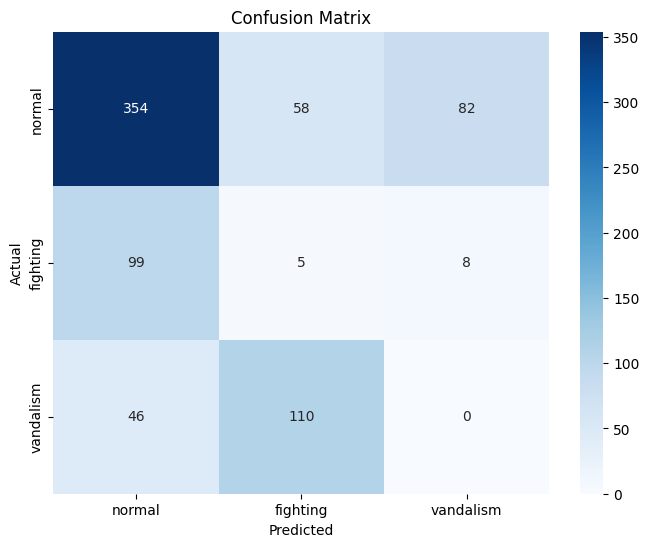

In [ ]:
from sklearn.metrics import confusion_matrix #1
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['normal', 'fighting', 'vandalism'], yticklabels=['normal', 'fighting', 'vandalism'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import tensorflow as tf
import os

def load_and_preprocess_image(path, target_size=(224, 224)):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = image / 255.0
    return image

def load_and_preprocess_sequence(sequence_folder, sequence_length=64, target_size=(224, 224)):
    frames = sorted([os.path.join(sequence_folder, img) for img in os.listdir(sequence_folder) if img.endswith('.jpg')])
    frames = frames[:sequence_length]
    frames = [load_and_preprocess_image(frame, target_size) for frame in frames]
    return tf.stack(frames)


In [ ]:
def create_tf_dataset(base_path, category, subcategory, sequence_length=64, target_size=(224, 224)):
    subcategory_path = os.path.join(base_path, category, f"{subcategory}_frames")
    sequence_folders = [os.path.join(subcategory_path, seq_folder) for seq_folder in os.listdir(subcategory_path) if os.path.isdir(os.path.join(subcategory_path, seq_folder))]
    labels = [subcategory] * len(sequence_folders)

    dataset = tf.data.Dataset.from_tensor_slices((sequence_folders, labels))

    def process_path(sequence_folder, label):
        sequence_folder = sequence_folder.numpy().decode('utf-8')
        frames = load_and_preprocess_sequence(sequence_folder, sequence_length, target_size)
        return frames, label_mapping[label.numpy().decode('utf-8')]

    def process_path_pyfunc(sequence_folder, label):
        return tf.py_function(func=process_path, inp=[sequence_folder, label], Tout=(tf.float32, tf.int32))

    dataset = dataset.map(process_path_pyfunc, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset


In [ ]:
# Define base path and labels
base_path = "/content/New__processed/Datasets_new"
categories = ["train", "valid", "test"]
subcategories = ["Fighting", "Vandalism", "normal_videos"]
label_mapping = {"Fighting": 0, "Vandalism": 1, "normal_videos": 2}

# Create datasets
train_dataset = create_tf_dataset(base_path, "train", "Fighting").concatenate(
                create_tf_dataset(base_path, "train", "Vandalism")).concatenate(
                create_tf_dataset(base_path, "train", "normal_videos"))
valid_dataset = create_tf_dataset(base_path, "valid", "Fighting").concatenate(
                create_tf_dataset(base_path, "valid", "Vandalism")).concatenate(
                create_tf_dataset(base_path, "valid", "normal_videos"))
test_dataset = create_tf_dataset(base_path, "test", "Fighting").concatenate(
               create_tf_dataset(base_path, "test", "Vandalism")).concatenate(
               create_tf_dataset(base_path, "test", "normal_videos"))

# Shuffle and batch datasets
train_dataset = train_dataset.shuffle(1000).batch(8).prefetch(tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.batch(8).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(8).prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
import tensorflow as tf

def load_and_preprocess_image(path, target_size=(224, 224)):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = image / 255.0
    return image


In [ ]:
def load_and_preprocess_sequence(sequence_folder, sequence_length=64, target_size=(224, 224)):
    frames = sorted([os.path.join(sequence_folder, img) for img in os.listdir(sequence_folder) if img.endswith('.jpg')])
    frames = frames[:sequence_length]
    frames = [load_and_preprocess_image(frame, target_size) for frame in frames]
    return tf.stack(frames)


In [ ]:
def create_tf_dataset(base_path, category, subcategory, sequence_length=64, target_size=(224, 224)):
    subcategory_path = os.path.join(base_path, category, f"{subcategory}_frames")
    sequence_folders = [os.path.join(subcategory_path, seq_folder) for seq_folder in os.listdir(subcategory_path) if os.path.isdir(os.path.join(subcategory_path, seq_folder))]
    labels = [subcategory] * len(sequence_folders)

    dataset = tf.data.Dataset.from_tensor_slices((sequence_folders, labels))

    def process_path(sequence_folder, label):
        return load_and_preprocess_sequence(sequence_folder, sequence_length, target_size), label_mapping[label]

    dataset = dataset.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset


In [ ]:
# Define base path and labels
base_path = "/content/New__processed/Datasets_new"
categories = ["train", "valid", "test"]
subcategories = ["Fighting", "Vandalism", "normal_videos"]
label_mapping = {"Fighting": 0, "Vandalism": 1, "normal_videos": 2}

# Create datasets
train_dataset = create_tf_dataset(base_path, "train", "Fighting").concatenate(
                create_tf_dataset(base_path, "train", "Vandalism")).concatenate(
                create_tf_dataset(base_path, "train", "normal_videos"))
valid_dataset = create_tf_dataset(base_path, "valid", "Fighting").concatenate(
                create_tf_dataset(base_path, "valid", "Vandalism")).concatenate(
                create_tf_dataset(base_path, "valid", "normal_videos"))
test_dataset = create_tf_dataset(base_path, "test", "Fighting").concatenate(
               create_tf_dataset(base_path, "test", "Vandalism")).concatenate(
               create_tf_dataset(base_path, "test", "normal_videos"))

# Shuffle and batch datasets
train_dataset = train_dataset.shuffle(1000).batch(8).prefetch(tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.batch(8).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(8).prefetch(tf.data.experimental.AUTOTUNE)


TypeError: in user code:

    File "<ipython-input-7-371ecdc00d60>", line 9, in process_path  *
        return load_and_preprocess_sequence(sequence_folder, sequence_length, target_size), label_mapping[label]
    File "<ipython-input-6-d12ac62dba7c>", line 2, in load_and_preprocess_sequence  *
        frames = sorted([os.path.join(sequence_folder, img) for img in os.listdir(sequence_folder) if img.endswith('.jpg')])

    TypeError: listdir: path should be string, bytes, os.PathLike, integer or None, not SymbolicTensor


In [ ]:
from concurrent.futures import ThreadPoolExecutor
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
import numpy as np

base_path = "/content/New__processed/Datasets_new"
def process_sequence_folder(seq_folder, sequence_length=64, target_size=(224, 224)):
    frames = sorted([os.path.join(seq_folder, img) for img in os.listdir(seq_folder) if img.endswith('.jpg')])
    if len(frames) == sequence_length:
        frames_array = [tf.keras.preprocessing.image.load_img(frame, target_size=target_size) for frame in frames]
        frames_array = [tf.keras.preprocessing.image.img_to_array(frame) for frame in frames_array]
        return frames_array
    return None

def create_sequence_dataset(base_path, categories, subcategories, sequence_length=64, target_size=(224, 224)):
    datasets = {}
    datagen = ImageDataGenerator(rescale=1./255)

    for category in categories:
        category_path = os.path.join(base_path, category)
        for subcategory in subcategories:
            subcategory_path = os.path.join(category_path, f"{subcategory}_frames")
            sequence_folders = [os.path.join(subcategory_path, seq_folder) for seq_folder in os.listdir(subcategory_path) if os.path.isdir(os.path.join(subcategory_path, seq_folder))]
            sequences = []
            labels = []

            with ThreadPoolExecutor() as executor:
                futures = [executor.submit(process_sequence_folder, seq_folder, sequence_length, target_size) for seq_folder in sequence_folders]
                for future in futures:
                    result = future.result()
                    if result is not None:
                        sequences.append(result)
                        labels.append(subcategory)

            datasets[category] = (sequences, labels)

    return datasets

# Create datasets
datasets = create_sequence_dataset(base_path, ["train", "valid", "test"], ["Fighting", "Vandalism", "normal_videos"])

train_sequences, train_labels = datasets['train']
valid_sequences, valid_labels = datasets['valid']
test_sequences, test_labels = datasets['test']

# Convert lists to numpy arrays and normalize
train_sequences = np.array(train_sequences, dtype=np.float32) / 255.0
valid_sequences = np.array(valid_sequences, dtype=np.float32) / 255.0
test_sequences = np.array(test_sequences, dtype=np.float32) / 255.0

# Convert labels to categorical
label_mapping = {"Fighting": 0, "Vandalism": 1, "normal_videos": 2}
train_labels = np.array([label_mapping[label] for label in train_labels], dtype=np.int32)
valid_labels = np.array([label_mapping[label] for label in valid_labels], dtype=np.int32)
test_labels = np.array([label_mapping[label] for label in test_labels], dtype=np.int32)


In [ ]:
import numpy as np
import os

# Create a directory to store the data
save_dir = "/content/saved_data"
os.makedirs(save_dir, exist_ok=True)

# Save train data
np.save(os.path.join(save_dir, "train_sequences.npy"), train_sequences)
np.save(os.path.join(save_dir, "train_labels.npy"), train_labels)

# Save validation data
np.save(os.path.join(save_dir, "valid_sequences.npy"), valid_sequences)
np.save(os.path.join(save_dir, "valid_labels.npy"), valid_labels)

# Save test data
np.save(os.path.join(save_dir, "test_sequences.npy"), test_sequences)
np.save(os.path.join(save_dir, "test_labels.npy"), test_labels)

print("Data saved successfully!")


Data saved successfully!


In [ ]:
import numpy as np
import os

# Load data in your new session
train_sequences = np.load(os.path.join(save_dir, "train_sequences.npy"))
train_labels = np.load(os.path.join(save_dir, "train_labels.npy"))

valid_sequences = np.load(os.path.join(save_dir, "valid_sequences.npy"))
valid_labels = np.load(os.path.join(save_dir, "valid_labels.npy"))

test_sequences = np.load(os.path.join(save_dir, "test_sequences.npy"))
test_labels = np.load(os.path.join(save_dir, "test_labels.npy"))


NameError: name 'save_dir' is not defined

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def build_i3d_model(input_shape=(64, 224, 224, 3), num_classes=3):
    inputs = layers.Input(shape=input_shape)

    base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape[1:])
    base_model.trainable = False

    time_distributed_features = layers.TimeDistributed(base_model)(inputs)
    x = layers.TimeDistributed(layers.GlobalAveragePooling2D())(time_distributed_features)
    x = layers.BatchNormalization()(x)
    x = layers.LSTM(512, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.LSTM(256, return_sequences=False, kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = models.Model(inputs=inputs, outputs=predictions)
    return model

# Prepare the datasets
input_shape = (64, 224, 224, 3)
num_classes = 3
i3d_model = build_i3d_model(input_shape=input_shape, num_classes=num_classes)

# Compile the model
initial_learning_rate = 1e-4
i3d_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Training the Model
history = i3d_model.fit(
    train_sequences, train_labels,
    epochs=100,
    validation_data=(valid_sequences, valid_labels),
    callbacks=[early_stopping, reduce_lr]
)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def build_i3d_model(input_shape=(64, 224, 224, 3), num_classes=3):
    inputs = layers.Input(shape=input_shape)

    base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape[1:])
    base_model.trainable = False

    time_distributed_features = layers.TimeDistributed(base_model)(inputs)
    x = layers.TimeDistributed(layers.GlobalAveragePooling2D())(time_distributed_features)
    x = layers.BatchNormalization()(x)
    x = layers.LSTM(512, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.LSTM(256, return_sequences=False, kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = models.Model(inputs=inputs, outputs=predictions)
    return model

# Prepare the datasets
input_shape = (64, 224, 224, 3)
num_classes = 3
i3d_model = build_i3d_model(input_shape=input_shape, num_classes=num_classes)

# Compile the model with class weights
initial_learning_rate = 1e-4
i3d_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Training the Model
history = i3d_model.fit(
    train_sequences, train_labels,
    epochs=100,
    validation_data=(valid_sequences, valid_labels),
    callbacks=[early_stopping, reduce_lr]
)


ValueError: Expected input data to be non-empty.

In [ ]:
# Cell 5: Build and compile the I3D model with updated parameters and training process
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def build_i3d_model(input_shape=(64, 224, 224, 3), num_classes=3):
    inputs = layers.Input(shape=input_shape)

    base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape[1:])
    base_model.trainable = False

    time_distributed_features = layers.TimeDistributed(base_model)(inputs)
    x = layers.TimeDistributed(layers.GlobalAveragePooling2D())(time_distributed_features)
    x = layers.BatchNormalization()(x)
    x = layers.LSTM(512, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.LSTM(256, return_sequences=False, kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = models.Model(inputs=inputs, outputs=predictions)
    return model

# Prepare the datasets
input_shape = (64, 224, 224, 3)
num_classes = 3
i3d_model = build_i3d_model(input_shape=input_shape, num_classes=num_classes)

# Define class weights based on the distribution
class_weights = {
    0: 1.0,  # normal_videos
    1: 3.0,  # Vandalism (adjust based on the imbalance)
    2: 3.0   # Fighting (adjust based on the imbalance)
}

# Compile the model with class weights
initial_learning_rate = 1e-4  # Slightly higher initial learning rate
i3d_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Training the Model with Class Weights
history = i3d_model.fit(train_dataset,
                        epochs=100,
                        validation_data=valid_dataset,
                        class_weight=class_weights,
                        callbacks=[early_stopping, reduce_lr])


Epoch 1/100


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_2" is incompatible with the layer: expected shape=(None, 64, 224, 224, 3), found shape=(64, 224, 224, 3)


In [ ]:
# Cell 6: Data augmentation and dataset preparation using ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_dataset = train_datagen.flow_from_directory(
    '/content/New__processed/Datasets_new/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

valid_dataset = valid_datagen.flow_from_directory(
    '/content/New__processed/Datasets_new/valid',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

Found 52312 images belonging to 6 classes.
Found 48850 images belonging to 6 classes.


In [ ]:
# Cell 7: Build and compile the I3D model with updated parameters and training process
from tensorflow.keras import layers, models, regularizers

def build_i3d_model(input_shape=(64, 224, 224, 3), num_classes=3):
    inputs = layers.Input(shape=input_shape)

    base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape[1:])
    base_model.trainable = False

    time_distributed_features = layers.TimeDistributed(base_model)(inputs)
    x = layers.TimeDistributed(layers.GlobalAveragePooling2D())(time_distributed_features)
    x = layers.BatchNormalization()(x)
    x = layers.LSTM(512, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.LSTM(256, return_sequences=False, kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = models.Model(inputs=inputs, outputs=predictions)
    return model

# Prepare the datasets
input_shape = (64, 224, 224, 3)
num_classes = 3
i3d_model = build_i3d_model(input_shape=input_shape, num_classes=num_classes)

# Define class weights based on the distribution
class_weights = {
    0: 1.0,  # normal_videos
    1: 3.0,  # Vandalism (adjust based on the imbalance)
    2: 3.0   # Fighting (adjust based on the imbalance)
}

# Compile the model with class weights
initial_learning_rate = 1e-4  # Slightly higher initial learning rate
i3d_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Training the Model with Class Weights
history = i3d_model.fit(train_dataset,
                        epochs=100,
                        validation_data=valid_dataset,
                        class_weight=class_weights,
                        callbacks=[early_stopping, reduce_lr])

In [ ]:
# Cell 6: Build and compile the I3D model with updated parameters and training process
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.applications import InceptionV3

# Enable mixed precision
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

def build_i3d_model(input_shape=(64, 224, 224, 3), num_classes=3):
    inputs = layers.Input(shape=input_shape)

    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape[1:])
    base_model.trainable = False

    time_distributed_features = layers.TimeDistributed(base_model)(inputs)
    x = layers.TimeDistributed(layers.GlobalAveragePooling2D())(time_distributed_features)
    x = layers.BatchNormalization()(x)
    x = layers.LSTM(512, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.LSTM(256, return_sequences=False, kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = Model(inputs=inputs, outputs=predictions)
    return model

# Prepare the datasets
input_shape = (64, 224, 224, 3)
num_classes = 3
i3d_model = build_i3d_model(input_shape=input_shape, num_classes=num_classes)

# Define class weights based on the distribution
class_weights = {
    0: 1.0,  # normal_videos
    1: 3.0,  # Vandalism (adjust based on the imbalance)
    2: 3.0   # Fighting (adjust based on the imbalance)
}

# Compile the model with class weights
initial_learning_rate = 1e-4  # Slightly higher initial learning rate
i3d_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'],
                  weighted_metrics=['accuracy'])

# Callbacks for Early Stopping and Learning Rate Reduction
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                   factor=0.5,
                                                   patience=5,
                                                   min_lr=1e-7,  # Allow lower minimum learning rate
                                                   verbose=1)

# Training the Model with Class Weights
num_epochs = 100
history = i3d_model.fit(train_dataset,
                        epochs=num_epochs,
                        validation_data=valid_dataset,
                        class_weight=class_weights,
                        callbacks=[early_stopping, lr_schedule])

Epoch 1/100
102/102 [==============================] - 135s 812ms/step - loss: 29.7605 - accuracy: 0.9044 - weighted_accuracy: 0.9132 - val_loss: 29.6526 - val_accuracy: 0.1693 - val_weighted_accuracy: 0.1693 - lr: 1.0000e-04
Epoch 2/100
102/102 [==============================] - 99s 745ms/step - loss: 27.2596 - accuracy: 0.9939 - weighted_accuracy: 0.9946 - val_loss: 27.6422 - val_accuracy: 0.1916 - val_weighted_accuracy: 0.1916 - lr: 1.0000e-04
Epoch 3/100
102/102 [==============================] - 99s 747ms/step - loss: 24.7932 - accuracy: 0.9877 - weighted_accuracy: 0.9901 - val_loss: 25.7208 - val_accuracy: 0.1850 - val_weighted_accuracy: 0.1850 - lr: 1.0000e-04
Epoch 4/100
102/102 [==============================] - 99s 746ms/step - loss: 22.2715 - accuracy: 0.9914 - weighted_accuracy: 0.9926 - val_loss: 23.4553 - val_accuracy: 0.1522 - val_weighted_accuracy: 0.1522 - lr: 1.0000e-04
Epoch 5/100
102/102 [==============================] - 99s 745ms/step - loss: 19.8184 - accuracy: 0

In [ ]:
# Evaluate the model on the test dataset(1)
test_loss, test_accuracy = i3d_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

40/40 [==============================] - 22s 321ms/step - loss: 4.0853 - accuracy: 0.4377 - weighted_accuracy: 0.4377


ValueError: too many values to unpack (expected 2)

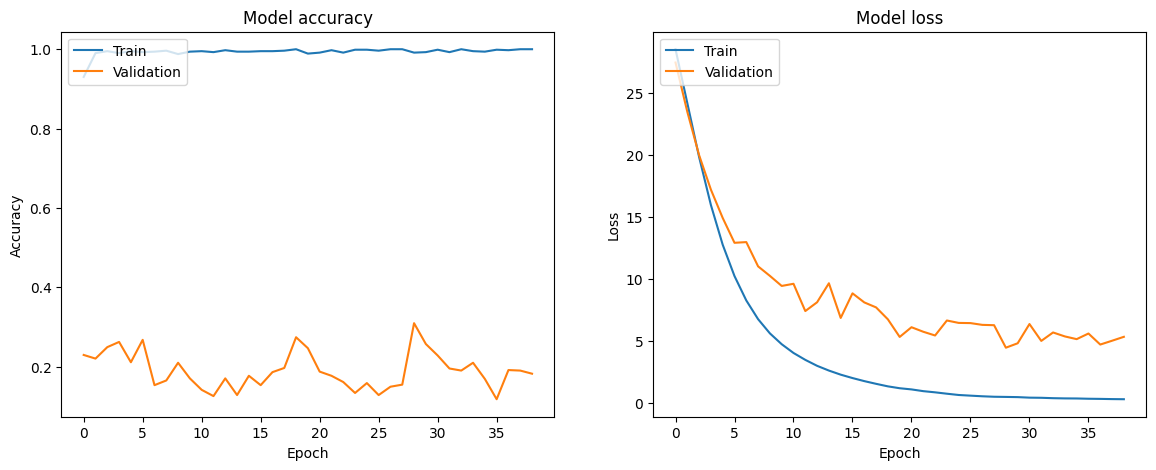

In [ ]:
import matplotlib.pyplot as plt # 1

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_training_history(history)


In [ ]:
from sklearn.metrics import classification_report #1
import numpy as np

# Get true labels and predictions
y_true = []
y_pred = []

for videos, labels in valid_dataset:
    predictions = i3d_model.predict(videos)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Generate classification report
print(classification_report(y_true, y_pred, target_names=['normal', 'fighting', 'vandalism']))


1/1 [==============================] - 0s 59ms/step
              precision    recall  f1-score   support

      normal       0.25      0.97      0.40       156
    fighting       0.69      0.39      0.50       112
   vandalism       0.47      0.08      0.14       494

    accuracy                           0.31       762
   macro avg       0.47      0.48      0.35       762
weighted avg       0.46      0.31      0.25       762



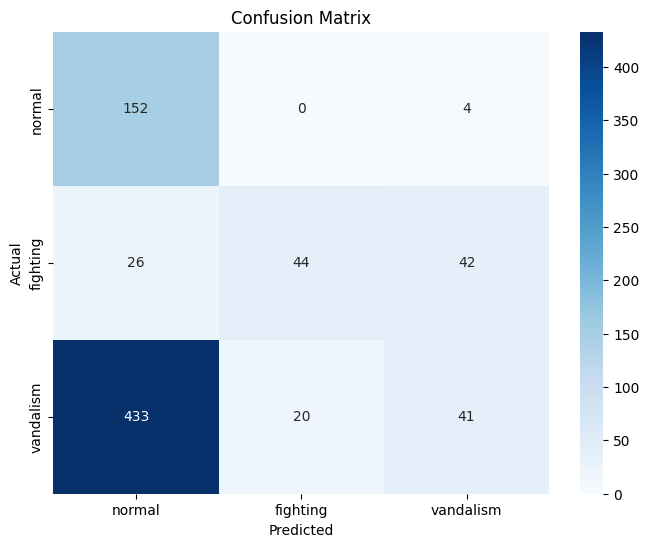

In [ ]:
from sklearn.metrics import confusion_matrix #1
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['normal', 'fighting', 'vandalism'], yticklabels=['normal', 'fighting', 'vandalism'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


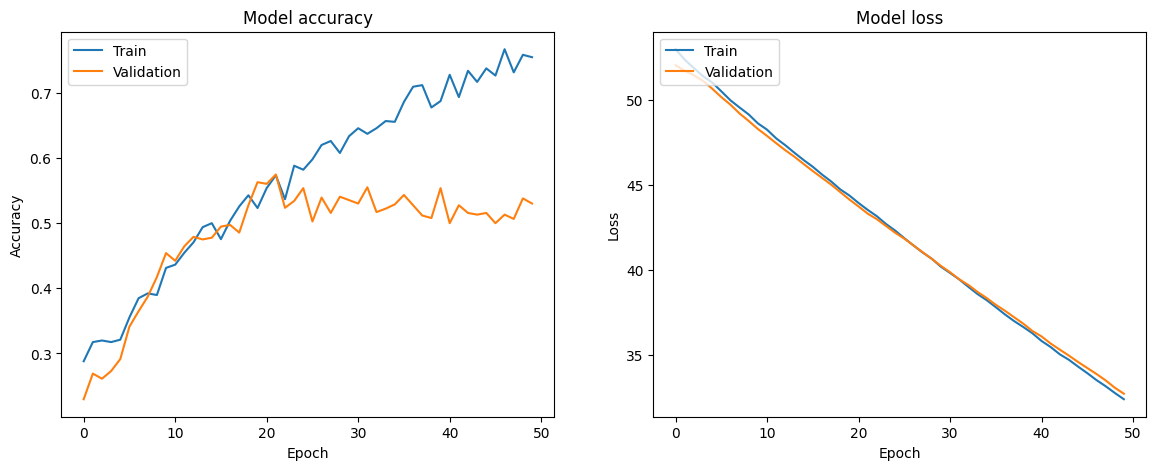

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_training_history(history)


In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = i3d_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

40/40 [==============================] - 12s 273ms/step - loss: 2.5866 - accuracy: 0.3450
Test Loss: 2.586609363555908
Test Accuracy: 0.3450479209423065


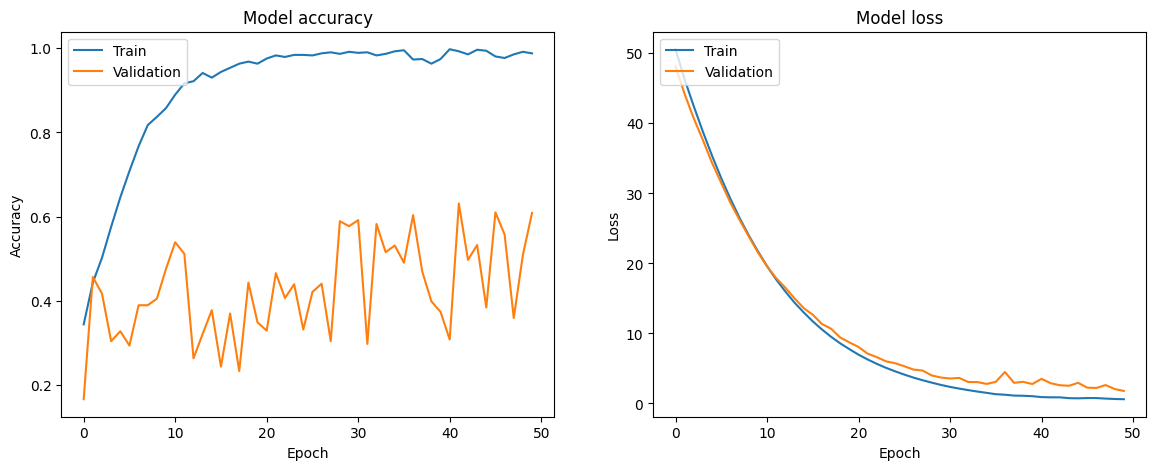

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_training_history(history)


In [ ]:

# Save the model to drive
model_save_path = '/content/drive/MyDrive/i3d_model(12).keras'
i3d_model.save(model_save_path)


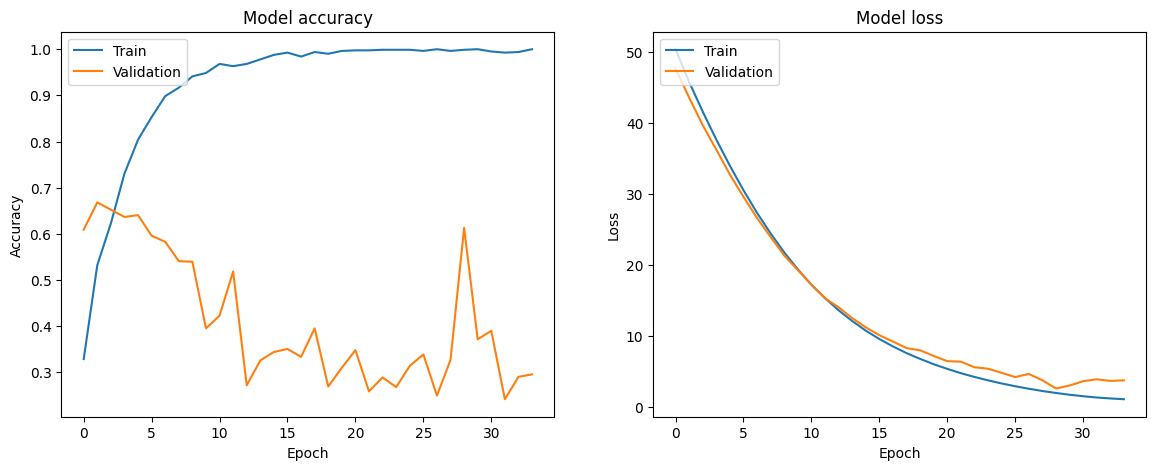

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_training_history(history)


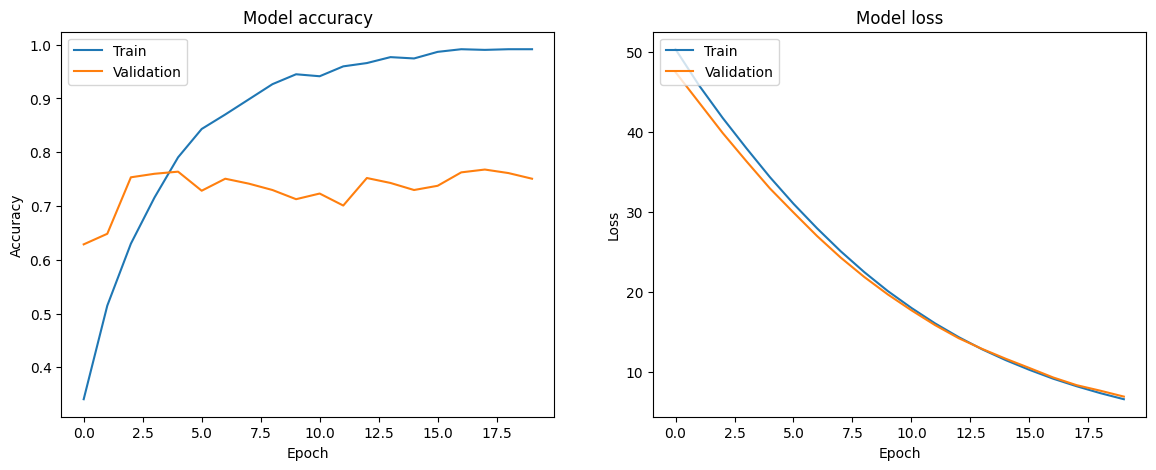

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_training_history(history)


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get true labels and predictions
y_true = []
y_pred = []

for videos, labels in valid_dataset:
    predictions = i3d_model.predict(videos)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Generate classification report
print(classification_report(y_true, y_pred, target_names=['normal', 'fighting', 'vandalism']))


1/1 [==============================] - 0s 60ms/step
              precision    recall  f1-score   support

      normal       0.89      0.56      0.69       156
    fighting       1.00      0.01      0.02       112
   vandalism       0.73      0.98      0.83       494

    accuracy                           0.75       762
   macro avg       0.87      0.51      0.51       762
weighted avg       0.80      0.75      0.68       762



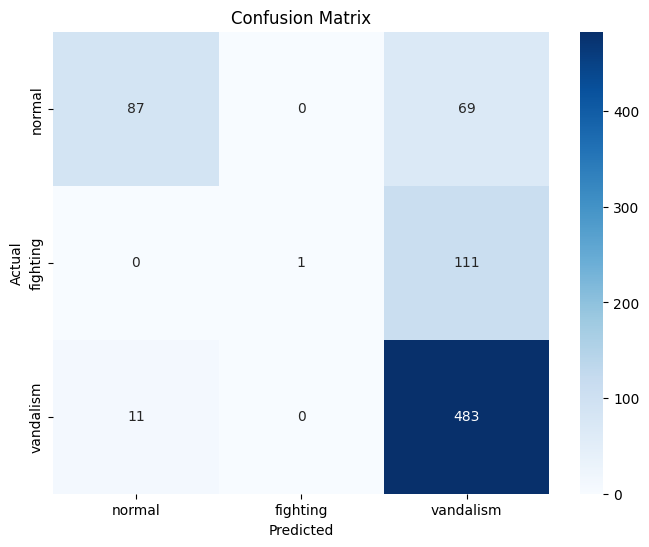

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['normal', 'fighting', 'vandalism'], yticklabels=['normal', 'fighting', 'vandalism'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import cv2
import os

def video_to_frames(video_path, output_folder):
    cap = cv2.VideoCapture(video_path)
    success, frame = cap.read()
    count = 0
    while success:
        frame_filename = os.path.join(output_folder, f"frame_{count:04d}.jpg")
        cv2.imwrite(frame_filename, frame)
        success, frame = cap.read()
        count += 1
    cap.release()
    return output_folder


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

def preprocess_frame(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = tf.image.per_image_standardization(img_array)  # Normalize
    return img_array


In [ ]:
def load_sequence_from_folder(folder_path, sequence_length=64):
    frame_files = sorted([os.path.join(folder_path, fname) for fname in os.listdir(folder_path) if fname.endswith('.jpg')])
    frames = np.array([preprocess_frame(f) for f in frame_files[:sequence_length]])
    frames = np.expand_dims(frames, axis=0)  # Add batch dimension
    return frames

def predict_and_display(sequence, model, label_mapping):
    predictions = model.predict(sequence)
    predicted_label = np.argmax(predictions[0])
    label_name = [name for name, index in label_mapping.items() if index == predicted_label][0]
    confidence = predictions[0][predicted_label]
    return label_name, confidence

# Define label mapping
label_mapping = {
    "normal_videos": 0,
    "Vandalism": 1,
    "Fighting": 2
}

# Example usage with a video file
video_path = '/content/drive/MyDrive/saved_model(new2)/Fighting007_x264.mp4'
output_folder = '/content/sample_data/fighting'

# Convert video to frames
output_folder = video_to_frames(video_path, output_folder)

# Load and preprocess frames
sequence = load_sequence_from_folder(output_folder)

# Predict
predicted_label, confidence = predict_and_display(sequence, i3d_model, label_mapping)

print(f"Predicted: {predicted_label}, Confidence: {confidence:.2f}")


1/1 [==============================] - 0s 48ms/step
Predicted: Fighting, Confidence: 0.69


In [ ]:
# Example usage with a video file
video_path = '/content/drive/MyDrive/saved_model(new2)/Fighting007_x264.mp4'
output_folder = '/content/sample_data/ex'


In [ ]:
import cv2
import os

# Load the video
video_path =  '/content/drive/MyDrive/saved_model(new2)/Fighting007_x264.mp4'
cap = cv2.VideoCapture(video_path)

# Define output folder for frames
output_folder = '/content/sample_data/ex1'
os.makedirs(output_folder, exist_ok=True)

# Extract frames from the video
success, frame = cap.read()
count = 0
while success:
    frame_filename = os.path.join(output_folder, f"frame_{count:04d}.jpg")
    cv2.imwrite(frame_filename, frame)
    success, frame = cap.read()
    count += 1

cap.release()


In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

def predict_frame(frame, model):
    # Preprocess the frame
    frame = cv2.resize(frame, (224, 224))
    frame = np.expand_dims(frame, axis=0)
    frame = frame / 255.0  # Normalize

    # Predict using the model
    prediction = model.predict(frame)
    return prediction

# Load the video
video_path = '/content/drive/MyDrive/saved_model(new2)/Fighting007_x264.mp4'
cap = cv2.VideoCapture(video_path)

# Predictions
predictions = []

# Loop through the frames and make predictions
while True:
    ret, frame = cap.read()
    if not ret:
        break  # Break the loop if no more frames

    # Predict the frame
    prediction = predict_frame(frame, i3d_model)
    predictions.append(prediction)

cap.release()

# Plot the predictions
plt.figure(figsize=(10, 5))
plt.plot(predictions)
plt.title('Frame-wise Anomaly Detection')
plt.xlabel('Frame')
plt.ylabel('Confidence')
plt.grid(True)
plt.show()


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'time_distributed_4' (type TimeDistributed).
    
    as_list() is not defined on an unknown TensorShape.
    
    Call arguments received by layer 'time_distributed_4' (type TimeDistributed):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float16)
      • training=False
      • mask=None
